<a href="https://colab.research.google.com/github/RileyWClarke/MLTSA_RClarke/blob/master/HW3/rclarke_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLTSA - Riley Clarke - HW3

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
plt.style.use("https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/fbb.mplstyle")

 
## Installing/importing FB Prophet

In [4]:
!pip install fbprophet

In [0]:
import fbprophet

In [0]:
from fbprophet import Prophet
from fbprophet import diagnostics

## Reading in Uber data from the following repo:

https://github.com/fivethirtyeight/uber-tlc-foil-response. 


In [0]:
#Builds a list of pandas dataframes from the github file urls:
a = []
for mon in ['apr', 'may', 'jun', 'jul', 'aug', 'sep']:
    df = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-' 
                     + mon + '14.csv')
    a.append(df)

In [0]:
#concatenates the list into a single df
uberrides = pd.concat(a)

In [9]:
uberrides.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [10]:
uberrides.shape

(4534327, 4)

### DATA PREPARATION 1: Converting time column to datetime type and creating new df with number of rides per day



In [0]:
uberrides["time"] = pd.to_datetime(uberrides['Date/Time'])

In [20]:
uberrides.head()

,Date/Time,Lat,Lon,Base,time
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512,2014-04-01 00:11:00
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512,2014-04-01 00:17:00
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512,2014-04-01 00:21:00
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512,2014-04-01 00:28:00
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512,2014-04-01 00:33:00


In [21]:
uberrides.iloc[0]["time"].date

<function Timestamp.date>

In [0]:
uberbyday = uberrides.groupby(uberrides["time"].dt.date).count() 
# Returns pandas df with the number of rows in uberrides for each distinct date

In [23]:
uberbyday.head()

,Date/Time,Lat,Lon,Base,time
time,,,,,
2014-04-01,14546,14546,14546,14546,14546
2014-04-02,17474,17474,17474,17474,17474
2014-04-03,20701,20701,20701,20701,20701
2014-04-04,26714,26714,26714,26714,26714
2014-04-05,19521,19521,19521,19521,19521


In [0]:
uberbyday = uberbyday.drop(columns=['Lat','Lon','Base','time'])

In [25]:
uberbyday.head()

,Date/Time
time,
2014-04-01,14546
2014-04-02,17474
2014-04-03,20701
2014-04-04,26714
2014-04-05,19521


FB Prophet needs us to rename our columns as 'y' for the endogenous variable (# of rides) and 'ds' for the exogenous variable (calendar date). 

In [0]:
uberbyday['ds'] = uberbyday.index

In [0]:
uberbyday.rename(columns={'Date/Time':'y'}, inplace=True)

In [28]:
uberbyday.head()

,y,ds
time,,
2014-04-01,14546,2014-04-01
2014-04-02,17474,2014-04-02
2014-04-03,20701,2014-04-03
2014-04-04,26714,2014-04-04
2014-04-05,19521,2014-04-05


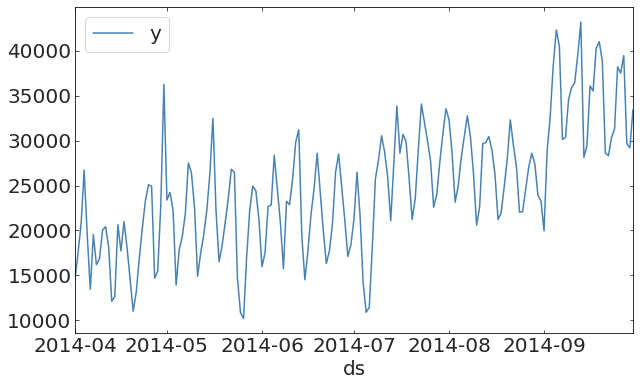

In [29]:
#Plotting the initial dataset
uberbyday.plot(x="ds", y="y");

Figure 1: Uber trips per day in NYC from 04-2014 to 10-2014. The data appears to display an increasing trend, with a possible point-of-change at the end of August. There also seems to be a quasi-periodicity with a frequency of 4/month, suggesting number of rides tend to spike on the weekends. 

## DATA PREPARATION 2: Standardization Boogaloo
Standarization will make the data more tractable and also convert the data type to floating points, which will aid regression later.

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


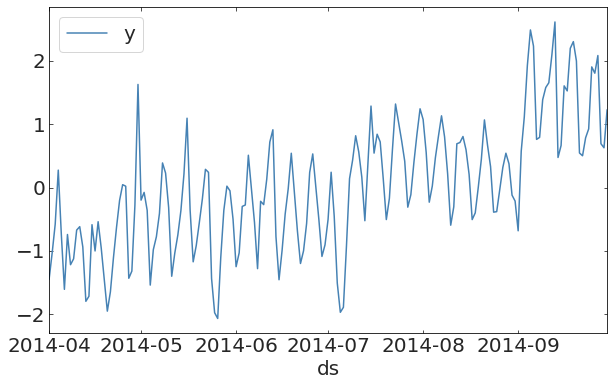

In [30]:
uberbyday['y'] = (uberbyday['y'] - uberbyday['y'].mean()) / uberbyday['y'].std()
uberbyday.plot(x="ds", y="y");

Figure 2: Same dataset as Figure 1, but with the data standarized to mean zero and standard deviation 1. 

## DATA ANALYSIS 
### MODEL 1: trends and seasonality

In [31]:
simplem = Prophet() #Invoking the Prophet model object
simplem.fit(uberbyday) #Fitting the model on the data

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
# Create a dataframe of dates one month past the end of the dataset
d=[]
for i in range(1,32):
  if i <= 9:
    d.append('2014-10-0'+str(i))
  if i > 9:
    d.append('2014-10-'+str(i))

future = pd.DataFrame(data = {'ds': d})

In [33]:
# and stitch it onto the end of the dataset
past_and_future = pd.concat([uberbyday, future])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [0]:
#use the fitted model to create a forecast of the dataset one month into the future
forecast = simplem.predict(past_and_future)

In [35]:
#Peek at the last 5 rows of the forecast:
forecast.iloc[-5:]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
209,2014-10-27,1.542582,0.281784,1.631373,1.542411,1.542744,-0.591815,-0.591815,-0.591815,-0.591815,-0.591815,-0.591815,0.0,0.0,0.0,0.950767
210,2014-10-28,1.555681,0.874378,2.173718,1.555500,1.555853,-0.027561,-0.027561,-0.027561,-0.027561,-0.027561,-0.027561,0.0,0.0,0.0,1.528120
211,2014-10-29,1.568780,1.203642,2.595517,1.568587,1.568960,0.316887,0.316887,0.316887,0.316887,0.316887,0.316887,0.0,0.0,0.0,1.885666
212,2014-10-30,1.581878,1.518263,2.874845,1.581671,1.582073,0.622970,0.622970,0.622970,0.622970,0.622970,0.622970,0.0,0.0,0.0,2.204848
213,2014-10-31,1.594977,1.478413,2.801347,1.594759,1.595182,0.533708,0.533708,0.533708,0.533708,0.533708,0.533708,0.0,0.0,0.0,2.128685


**==> there should be only 212 entries in the forecast dataframe, check your data cleasing code above**

As a check, we can see that the forecast dataframe extends to Oct 31st, one month past the original dataframe.

In [40]:
forecast['ds'].iloc[-31]

Timestamp('2014-10-01 00:00:00')

In [41]:
#Increase in trend value over month of October
forecast['trend'].iloc[-1] - forecast['trend'].iloc[-31]

0.3929627155313853

From Oct 1st to Oct 31st, the forecasted trend increased by about 0.4 standard deviations

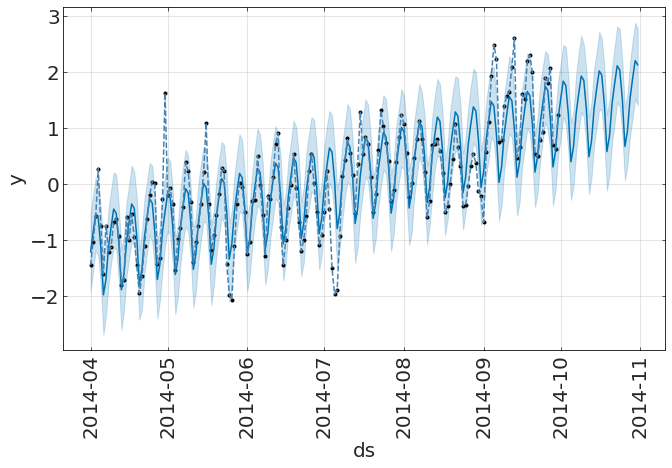

In [36]:
#Plotting original data + forecast
fig1 = simplem.plot(forecast)
plt.plot(uberbyday.y, '--')
plt.xticks(rotation=90);

Figure 3: Data from Figures 1 & 2 (scatterplot/dashed blue line) superimposed with forecasted data (solid blue line with shaded uncertainties). The forecast clearly shows the upward trend continuing into October, with an additional ~0.4$\sigma$ growth.

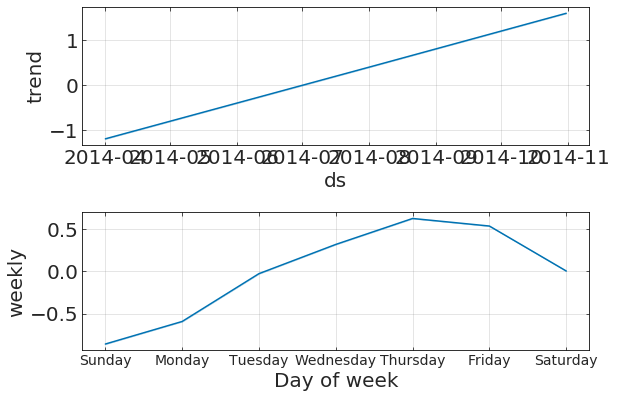

In [37]:
fig2 = simplem.plot_components(forecast)
plt.xticks(fontsize=14)
plt.show()

Figure 4: The upper plot shows the total forecasted trend, which more clearly illustrates the ~0.4$\sigma$ increase. The lower plot shows the weekly trend of the forecast, showing that rides actually tend to spike on Thursday/Friday, not over the weekend like I predicted eariler!

(Also, not sure how to fix the upper xticks since the plot_components method does not return a matplotlib subplots object)

## Model Validation

Crossvalidation and Chi-Square GOF Estimation

In [42]:
#Check number of model params
simplem.params

{'beta': array([[ 0.0092499 ,  0.26974939,  0.04441529, -0.04909549, -0.02075709,
          0.01797847]]),
 'delta': array([[ 7.14616084e-10,  8.60519151e-09,  5.38072861e-10,
          1.29506889e-08,  8.20718173e-09,  2.00526202e-09,
         -8.63506633e-09, -6.16822868e-10, -2.26062961e-09,
          1.23437037e-07,  4.01827034e-07,  1.17532212e-07,
          6.50899998e-05,  1.09545517e-03,  3.48319179e-04,
          1.53557601e-05,  4.43774031e-03,  2.81219510e-04,
          7.70055757e-06,  4.90092746e-05,  9.36295543e-06,
          7.06914051e-08,  2.08946821e-05,  3.52118803e-07,
         -2.17981412e-09]]),
 'k': array([[0.90686429]]),
 'm': array([[-0.45445293]]),
 'sigma_obs': array([[0.19974538]])}

This model has 5 parameters: $\beta$, $\delta$, k, m, and $\sigma_{obs}$

In [0]:
def rchi2(y, ytrue, nparams):
    '''
    Returns the reduced Chi-Square goodness of fit metric for a given number of model parameters
    ===============
    y: y-values produced by model
    ytrue: y-values of real dataset
    nparams: number of model parameters

    returns:
    reduced chi-square GOF (float)
    '''
    return np.sum( ((y-ytrue)**2) ) / (len(y) - nparams) #Note uncertainties are set to 1

In [45]:
#Computing the cross-validaton
cvresult_simplem = diagnostics.cross_validation(simplem, '30 days')
cvresult_simplem

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-07-03,0.474445,-0.017932,1.002017,-0.450615,2014-07-02
1,2014-07-04,0.474838,-0.057829,0.996609,-1.505913,2014-07-02
2,2014-07-05,-0.263004,-0.777892,0.295977,-1.967473,2014-07-02
3,2014-07-06,-1.073989,-1.612804,-0.524824,-1.889129,2014-07-02
4,2014-07-07,-0.722523,-1.254002,-0.227006,-0.920533,2014-07-02
...,...,...,...,...,...,...
145,2014-09-26,1.159241,0.560360,1.744430,1.802925,2014-08-31
146,2014-09-27,0.540499,0.010042,1.132883,2.081164,2014-08-31
147,2014-09-28,-0.165955,-0.721119,0.403276,0.691101,2014-08-31
148,2014-09-29,0.185216,-0.399749,0.789683,0.626642,2014-08-31


In [46]:
rchi2(cvresult_simplem['yhat'], cvresult_simplem['y'], 5)

0.47610571629587883

# DATA ACQUISITION 2: WWO Weather Data 

Collecting NYC weather data for the relevant timeframe from the www.worldweatheronline.com API

In [48]:
!pip install wwo_hist

  Created wheel for wwo-hist: filename=wwo_hist-0.0.4-cp36-none-any.whl size=4216 sha256=b64f409066309991a26fc06561d5abf3c8a3cf249ec2a5b3b4784d289f6cba3b
  Stored in directory: /root/.cache/pip/wheels/c5/0e/16/329d9233f3b0b7e5fe81b09c5519a193727999c6ae77577ca9
Successfully built wwo-hist


In [0]:
from wwo_hist import retrieve_hist_data

In [50]:
from google.colab import drive

drive.mount("/content/gdrive")


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [51]:
cd gdrive/My\ Drive

/content/gdrive/My Drive


In [52]:
!pwd

/content/gdrive/My Drive


In [53]:
frequency = 24 #frequency in hours (1/24 hours = 1/day)
start_date = '2014-04-01'
end_date = '2014-09-30'
api_key = pd.read_csv("my_apis.csv", header=None, index_col=0).loc["wwo"].values[0]
location_list = ['New+york,ny']
hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = True)



Retrieving weather data for New+york,ny


Currently retrieving data for New+york,ny: from 2014-04-01 to 2014-04-30
Time elapsed (hh:mm:ss.ms) 0:00:01.077247
Currently retrieving data for New+york,ny: from 2014-05-01 to 2014-05-31
Time elapsed (hh:mm:ss.ms) 0:00:02.013493
Currently retrieving data for New+york,ny: from 2014-06-01 to 2014-06-30
Time elapsed (hh:mm:ss.ms) 0:00:02.937278
Currently retrieving data for New+york,ny: from 2014-07-01 to 2014-07-31
Time elapsed (hh:mm:ss.ms) 0:00:04.183391
Currently retrieving data for New+york,ny: from 2014-08-01 to 2014-08-31
Time elapsed (hh:mm:ss.ms) 0:00:05.036898
Currently retrieving data for New+york,ny: from 2014-09-01 to 2014-09-30
Time elapsed (hh:mm:ss.ms) 0:00:05.867777
Currently retrieving data for New+york,ny: from 2014-09-01 to 2014-09-30
Time elapsed (hh:mm:ss.ms) 0:00:06.696265


export New+york,ny completed!




In [54]:
weather = pd.read_csv("New+york,ny.csv")
weather['date_time'] = pd.to_datetime(weather['date_time'])#Convert weather timestamps to pandas datetime type
weather.head()

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,moonrise,moonset,sunrise,sunset,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2014-04-01,12,2,0.0,12.8,1,1,5,06:41 AM,08:41 PM,05:40 AM,06:21 PM,4,6,8,6,16,10,77,0.0,1019,12,10,269,11
1,2014-04-02,12,4,0.0,12.8,1,1,13,07:21 AM,09:44 PM,05:38 AM,06:22 PM,5,7,8,7,10,27,83,0.2,1019,12,9,208,6
2,2014-04-03,13,6,0.0,12.9,1,1,21,08:03 AM,10:41 PM,05:37 AM,06:23 PM,6,9,10,9,12,23,75,0.0,1018,13,10,209,7
3,2014-04-04,6,5,0.0,8.1,1,1,28,08:49 AM,11:34 PM,05:35 AM,06:24 PM,4,3,6,3,22,95,87,4.5,1015,6,9,96,15
4,2014-04-05,10,3,0.0,12.9,1,1,36,09:38 AM,No moonset,05:33 AM,06:25 PM,2,3,7,3,29,29,76,0.1,1012,10,9,259,19


In [55]:
weather.rename(columns = {'date_time':'ds'}, inplace=True) #Rename datetime column to ds to merge with uberbyday df
weather.head()

,ds,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,moonrise,moonset,sunrise,sunset,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2014-04-01,12,2,0.0,12.8,1,1,5,06:41 AM,08:41 PM,05:40 AM,06:21 PM,4,6,8,6,16,10,77,0.0,1019,12,10,269,11
1,2014-04-02,12,4,0.0,12.8,1,1,13,07:21 AM,09:44 PM,05:38 AM,06:22 PM,5,7,8,7,10,27,83,0.2,1019,12,9,208,6
2,2014-04-03,13,6,0.0,12.9,1,1,21,08:03 AM,10:41 PM,05:37 AM,06:23 PM,6,9,10,9,12,23,75,0.0,1018,13,10,209,7
3,2014-04-04,6,5,0.0,8.1,1,1,28,08:49 AM,11:34 PM,05:35 AM,06:24 PM,4,3,6,3,22,95,87,4.5,1015,6,9,96,15
4,2014-04-05,10,3,0.0,12.9,1,1,36,09:38 AM,No moonset,05:33 AM,06:25 PM,2,3,7,3,29,29,76,0.1,1012,10,9,259,19


In [56]:
#Convert uberbyday['ds'] to datetime because it wasn't so before?
uberbyday['ds'] = pd.to_datetime(uberbyday['ds'])
uberbyday['ds']

time
2014-04-01   2014-04-01
2014-04-02   2014-04-02
2014-04-03   2014-04-03
2014-04-04   2014-04-04
2014-04-05   2014-04-05
                ...    
2014-09-26   2014-09-26
2014-09-27   2014-09-27
2014-09-28   2014-09-28
2014-09-29   2014-09-29
2014-09-30   2014-09-30
Name: ds, Length: 183, dtype: datetime64[ns]

In [0]:
#Merge the dataframes:
uberweather = uberbyday.merge(weather, on='ds')

In [58]:
uberweather

,y,ds,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,moonrise,moonset,sunrise,sunset,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,-1.449528,2014-04-01,12,2,0.0,12.8,1,1,5,06:41 AM,08:41 PM,05:40 AM,06:21 PM,4,6,8,6,16,10,77,0.0,1019,12,10,269,11
1,-1.034719,2014-04-02,12,4,0.0,12.8,1,1,13,07:21 AM,09:44 PM,05:38 AM,06:22 PM,5,7,8,7,10,27,83,0.2,1019,12,9,208,6
2,-0.577551,2014-04-03,13,6,0.0,12.9,1,1,21,08:03 AM,10:41 PM,05:37 AM,06:23 PM,6,9,10,9,12,23,75,0.0,1018,13,10,209,7
3,0.274309,2014-04-04,6,5,0.0,8.1,1,1,28,08:49 AM,11:34 PM,05:35 AM,06:24 PM,4,3,6,3,22,95,87,4.5,1015,6,9,96,15
4,-0.744721,2014-04-05,10,3,0.0,12.9,1,1,36,09:38 AM,No moonset,05:33 AM,06:25 PM,2,3,7,3,29,29,76,0.1,1012,10,9,259,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,0.691101,2014-09-28,26,15,0.0,11.6,1,1,27,10:02 AM,08:23 PM,05:50 AM,05:43 PM,18,23,24,23,11,14,76,0.0,1019,26,10,206,6
209,0.626642,2014-09-29,24,17,0.0,8.8,1,1,34,11:01 AM,09:12 PM,05:51 AM,05:42 PM,15,21,21,21,11,60,70,0.1,1014,24,10,248,6
210,0.626642,2014-09-29,24,17,0.0,8.8,1,1,34,11:01 AM,09:12 PM,05:51 AM,05:42 PM,15,21,21,21,11,60,70,0.1,1014,24,10,248,6
211,1.225904,2014-09-30,21,17,0.0,10.2,1,1,42,11:59 AM,10:05 PM,05:52 AM,05:40 PM,16,19,19,19,11,55,83,0.8,1014,21,7,146,8


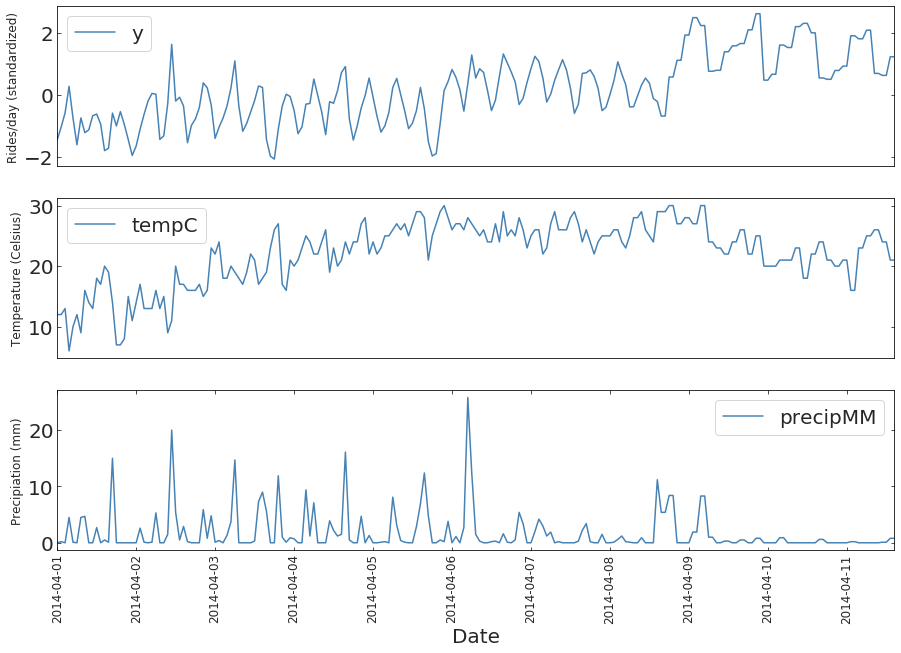

In [81]:
fig, ax = plt.subplots(3, figsize = (15,10))
uberweather.plot(y="y", ax=ax[0])
uberweather.plot(y="tempC", ax=ax[1])
uberweather.plot(y="precipMM", ax=ax[2])
plt.xlabel('Date')
ax[0].set_ylabel('Rides/day (standardized)', fontsize=12)
ax[1].set_ylabel('Temperature (Celsius)', fontsize=12)
ax[2].set_ylabel('Precipiation (mm)', fontsize=12)
ax[0].set_xticks([])
ax[1].set_xticks([])
plt.xticks(range(0,len(uberweather),20), uberweather['ds'].dt.date,rotation=90, fontsize=12);

Figure 5: The top plot shows our original series (standarized rides per day) with days since 2014-04-01 on the x-axis. The middle plot shows average daily temperature in degrees Celsius over that time period, and the bottoms shows daily precipitation in millimeters of rainwater over the time period. We might naively expect days with high precipitation and/or lower average temperatures to produce increases in rides/day. We'll see if adding these features as regressors improves the GOF of our model.

**==>Should standardize the temperature and precipition**

## MODEL 2: Regressors
Simple model used earlier, but with temperature and precipitation features added as regressors.

In [0]:
regrm = Prophet()
regrm.add_regressor('tempC')
regrm.add_regressor('precipMM');

In [85]:
regrm.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [86]:
cvresult_regrm = diagnostics.cross_validation(regrm, '30 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


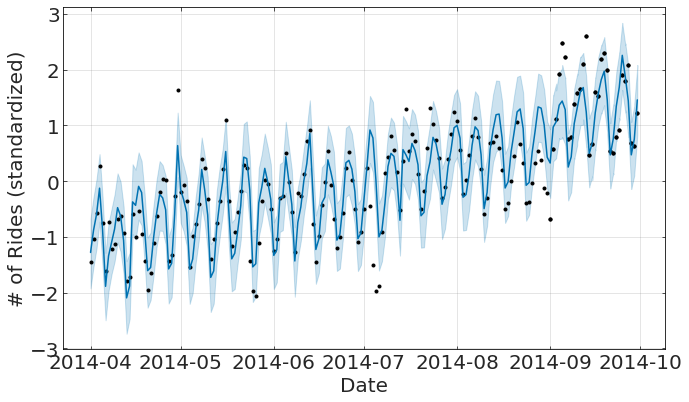

In [90]:
nowcast = regrm.predict(uberweather)
regrm.plot(nowcast)
plt.ylabel('# of Rides (standardized)')
plt.xlabel('Date')
plt.show()

Figure 4: Standardized rides/day with temperature and precipitation regressors added to our model. Comparing to Figure 3 (the simple model w/o regressors) we can see that weather has a pronounced effect on the model, causing some short-timescale changes while preserving the overall trend.

In [92]:
regrm.params

{'beta': array([[ 0.03912349,  0.25663084,  0.02846218, -0.05532945, -0.02825398,
          0.0257423 , -0.08702053,  0.07115205]]),
 'delta': array([[-3.25601677e-09, -1.02679428e-09,  2.24184117e-09,
         -4.24056279e-09,  2.79095334e-09, -8.14347788e-10,
          1.11526903e-09,  6.47382464e-11,  1.26028446e-06,
         -2.23988656e-09, -3.47049370e-10,  3.98852794e-09,
          3.07507380e-03,  7.49488758e-07,  3.26230248e-10,
         -1.81331045e-09,  2.17247352e-07,  3.73351493e-09,
         -1.60516870e-09,  1.50243958e-09,  1.42449297e-09,
          1.31136812e-09,  7.28944483e-10,  2.06865025e-10,
         -1.88539489e-09]]),
 'k': array([[1.18208561]]),
 'm': array([[-0.58702426]]),
 'sigma_obs': array([[0.18402838]])}

Again, our model has the same 5 parameters

In [91]:
rchi2(cvresult_regrm['yhat'], cvresult_regrm['y'], 5)

0.5490993626794071

Hmm our chi-square increased after adding the regressors...

# MODEL 3 add holidays
Holidays naturally affect rides per day, so we can implement US holidays using the add_country_holidays() Prophet method.


In [93]:
regholm = Prophet()
regholm.add_regressor('tempC')
regholm.add_regressor('precipMM');
regholm.add_country_holidays(country_name='US')

In [94]:
regholm.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


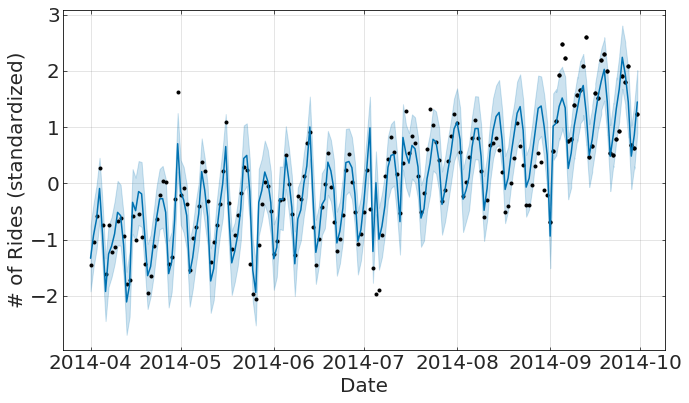

In [96]:
herecast = regholm.predict(uberweather)
regholm.plot(herecast)
plt.ylabel('# of Rides (standardized)')
plt.xlabel('Date')
plt.show()

Figure 6: Rides per day model with temperature and precipitation added as regressors, as well as US holidays added. Note the major dip in ridership the end of August (Labor Day?) and the beginning of July (Independence Day?)

In [102]:
cvresult_regholm = diagnostics.cross_validation(regholm, '30 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


In [103]:
regholm.params

{'beta': array([[ 0.04126417,  0.25014222,  0.04349785, -0.04846057, -0.03679054,
          0.01591347,  0.        ,  0.        , -0.79130563, -0.53963038,
          0.        , -0.21414957,  0.        ,  0.        ,  0.        ,
          0.        , -0.08294724,  0.07888712]]),
 'delta': array([[-2.02807909e-11,  1.72415354e-10,  6.44523672e-09,
         -5.72575488e-09,  5.96768420e-10,  5.37019025e-10,
          8.97280970e-10,  3.06872616e-09,  6.61151469e-09,
         -1.49620436e-09,  1.49338965e-08,  1.41620793e-08,
          8.86593600e-09,  3.72584677e-05,  3.54733330e-07,
          2.94279375e-08,  9.21235556e-09,  1.01023464e-08,
          3.84767205e-09, -1.51933456e-09,  7.52424148e-09,
          4.94119321e-08, -5.13689092e-09,  2.37971741e-09,
          2.90233433e-10]]),
 'k': array([[1.19189533]]),
 'm': array([[-0.58248283]]),
 'sigma_obs': array([[0.16939664]])}

In [104]:
rchi2(cvresult_regholm['yhat'], cvresult_regholm['y'], 5)

0.4639629930684204

Ok, so the chi-square decreased when adding holidays, suggesting holidays indeed have a pronounced effect on Uber ridership

# MODEL 4: Markov-Chain Monte Carlo optimization 
FB Prophet comes with a built-in MCMC optimization functionality, so we'll build a fourth model with a 5000-sample MCMC 

In [98]:
regmcmc = Prophet(mcmc_samples=5000)
regmcmc.add_regressor('tempC')
regmcmc.add_regressor('precipMM');
regmcmc.add_country_holidays(country_name='US')
regmcmc.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


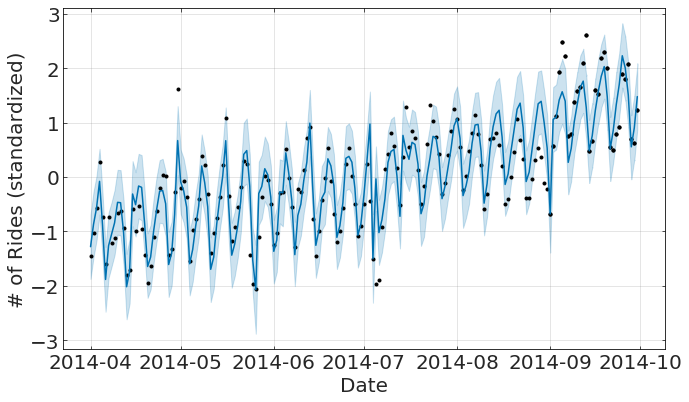

In [99]:
mcmccast = regmcmc.predict(uberweather)
regmcmc.plot(mcmccast)
plt.ylabel('# of Rides (standardized)')
plt.xlabel('Date')
plt.show()

Figure 7: Rides per day model with temperature/precipitation regressors, holidays, and MCMC optimization. Bit tough to see by eye if the MCMC changed the forecast by much compared to previous models, but we can check the chi-square result.

In [107]:
cvresult_regmcmc = diagnostics.cross_validation(regmcmc, '30 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


In [108]:
regmcmc.params

{'beta': array([[ 1.71456931e-02,  2.48451954e-01,  4.62325509e-02, ...,
         -3.05720074e-01, -7.86472335e-02,  7.42669268e-02],
        [ 3.71739610e-02,  2.51777472e-01,  3.03561179e-02, ...,
          4.53693104e-03, -7.31084408e-02,  9.72788255e-02],
        [ 6.07663947e-02,  2.69069057e-01,  9.88401120e-03, ...,
          1.14269971e+01, -5.85765812e-02,  8.75196214e-02],
        ...,
        [ 4.38020134e-02,  2.43299818e-01,  4.59180268e-02, ...,
          2.06769940e+00, -5.65414740e-02,  9.07093464e-02],
        [ 2.28056884e-02,  2.73713929e-01,  5.78167333e-02, ...,
         -2.72696757e+00, -6.60401279e-02,  9.04208682e-02],
        [ 2.14220299e-02,  2.63252928e-01,  1.77325358e-02, ...,
         -7.58400298e+00, -3.17105170e-02,  6.97083525e-02]]),
 'delta': array([[ 6.06068693e-02, -4.27602363e-02, -1.37347573e-01, ...,
         -4.98241841e-03, -5.31605969e-02,  4.78363116e-02],
        [ 4.55119459e-02,  5.57715553e-02,  2.01239263e-03, ...,
          8.65641448e

In [109]:
rchi2(cvresult_regmcmc['y'], cvresult_regmcmc['yhat'], 5)

0.49364441086582517

So the chi-square increased a bit compared to the regression+holidays model. I would have expected the chi square to decrease, but without knowing the details of Prophet's MCMC implementation, it's difficult to pin down why that didn't happen.

### Summary of Model Performance:

Model  | $\chi^2$          |
-------|-------------------|
simplem|0.47610571629587883|
regrm  |0.5490993626794071 |
regholm|0.4639629930684204 |
regmcmc|0.49364441086582517|

